In [1]:
import IsoDAT2D as iso
import SimDAT2D.SimDAT2D as sim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import pyFAI, fabio
from pyFAI.gui import jupyter
import pyFAI
import os
import matplotlib.pyplot as plt
import masking
import cupy
import nimfa

In [2]:
print(dir(sim))

['AI', 'Image', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'combine_image', 'create_anisotropic', 'create_iso_no_input', 'create_isotropic', 'create_mask', 'csv', 'dask', 'delayed', 'generate_mask_slices', 'generate_noisemap', 'image_rotation', 'integrate_image', 'jupyter', 'ma', 'make_chi_array', 'make_substrate_dict', 'mask_rotation', 'ndimage', 'np', 'parse_file', 'pd', 'plot_data', 'plt', 'pyFAI', 'read_poni_file', 'rnd', 'rotate_and_integrate', 'rotate_generated_mask', 'rotate_image', 'rotate_mask_360', 'save_data', 'scipy_rotate', 'slice_mask', 'subtract_and_store']


In [3]:
#masking algoirthm to create masks for the data

def make_masks(array, slices, offset = 5, width=.5, gits = False):
    masks = []
    mask_2048 = np.zeros((2048, 2048), dtype=bool)
    mask_2048[1024:] = True
    for i in slices:
        masks.append(masking.generate_mask_slices(array, width, i, offset = offset))
        print('Mask with {} slices created'.format(i))
        if gits == True:
            gits_masks = []
            for i in range(len(masks)):
                masks_p = masks[i] + mask_2048
                gits_masks.append(masks_p)
                plt.imshow(masks_p)
    return gits_masks

In [4]:
# Load the TIFF file
os.chdir(r'/blue/mbutala/dalverson/IsoDAT_Experiment_Data/NSLS-II')

file_path = 'Xtalline_GST_SC_avg_im.tiff'
image = fabio.open(file_path).data

os.chdir(r'/blue/mbutala/dalverson/IsoDAT_Experiment_Data/NSLS-II')

file_path4 = 'SC_avg_im.tiff'
image4 = fabio.open(file_path4).data

os.chdir(r'/blue/mbutala/dalverson/IsoDAT_Experiment_Data/NSLS-II')
my_poni = 'Ni_calib_20210711-135644_f555fb_0001.poni'

my_ground_truth = '0C_HT02_GST_FS_Sub-Sub.xy'

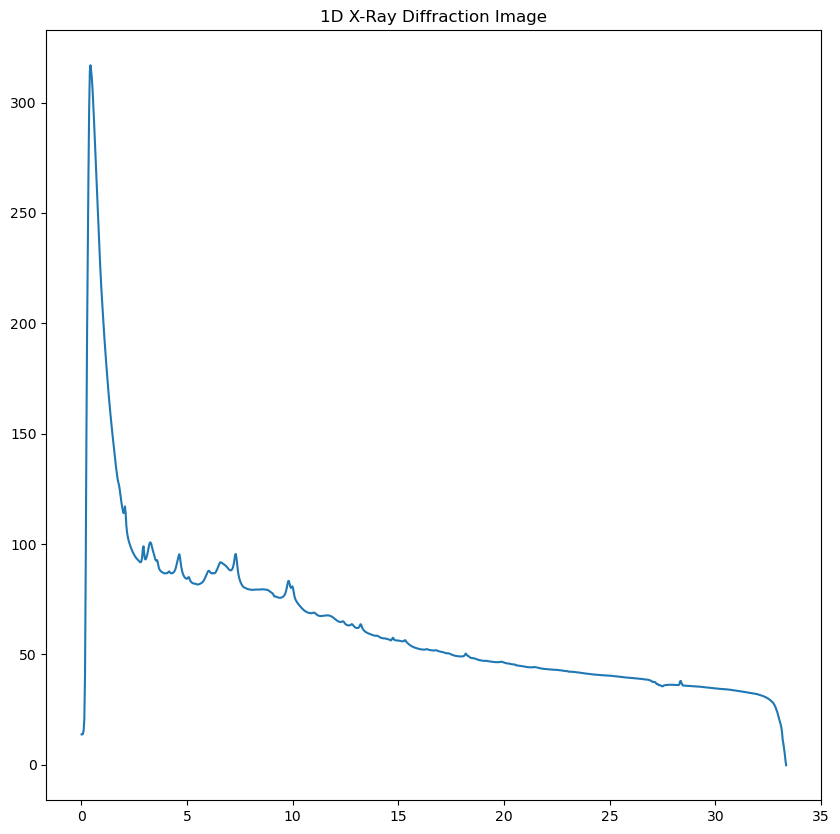

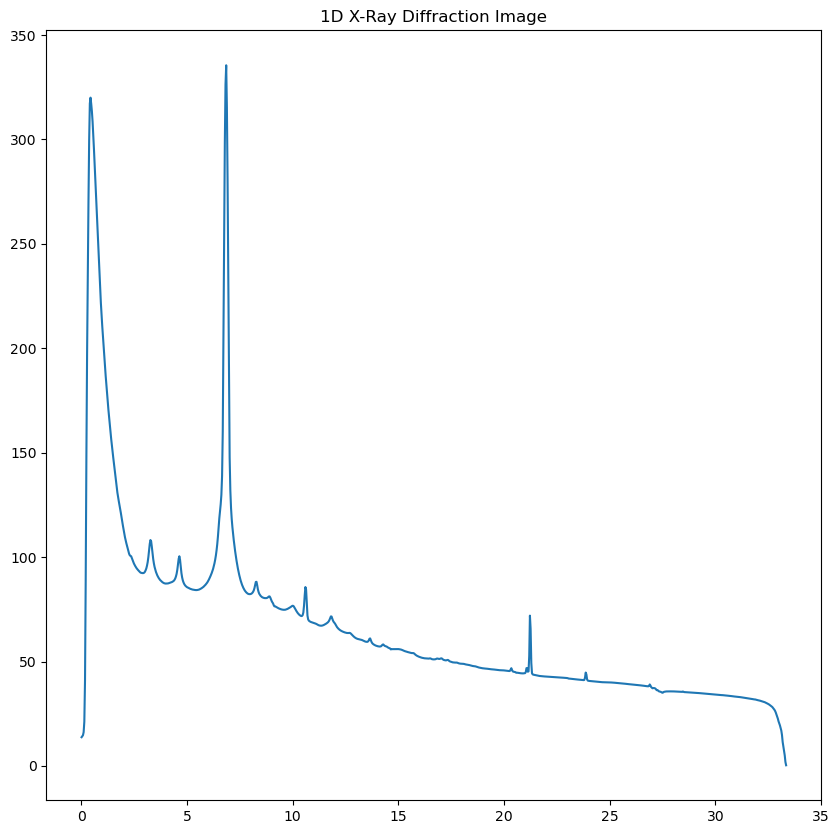

In [5]:
q, thin_film = sim.integrate_image(image, .4, .122e-10, resolution = 1024, show = True, poni = my_poni)
q, substrate_im = sim.integrate_image(image4, .4, .122e-10, resolution = 1024,  show = True, poni = my_poni)

1024

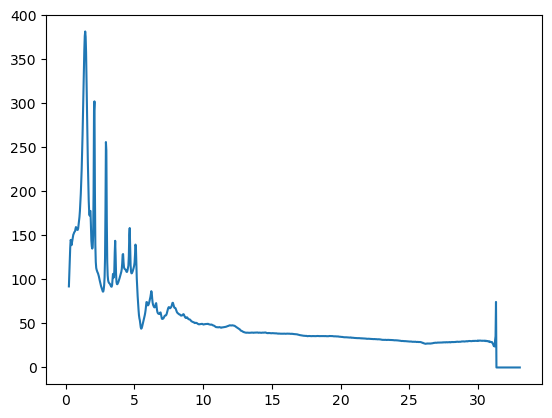

In [6]:
my_ground_truth = pd.read_csv('0C_HT02_GST_FS_Sub-Sub.xy', delimiter = ' ', header = None)
my_ground_truth = my_ground_truth.to_numpy()
plt.plot(my_ground_truth[:,0], my_ground_truth[:,1])
len(my_ground_truth)

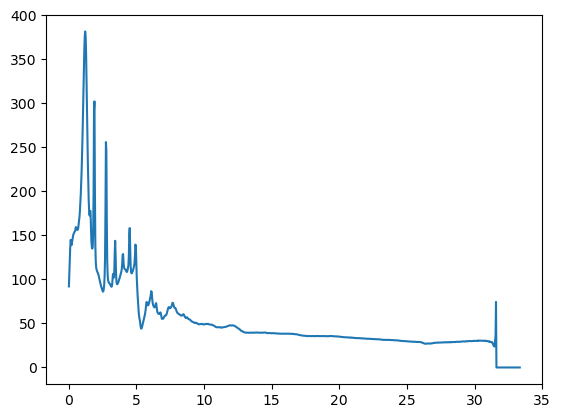

In [7]:
plt.plot(q, my_ground_truth[:,1])

In [8]:
#combine data from the two integrations

combined = np.array([thin_film, substrate_im])

#combined_reshaped = combined.reshape(-1, 1)
c_T = combined.transpose()
print(c_T.shape)

(1024, 2)


In [9]:
import numpy as np
from sklearn.decomposition import NMF
import logging
import warnings
import random
import matplotlib.pyplot as plt

In [10]:
def nmf(data, randomize_init=True, max_iter=200):
    
    
    best_W, best_H = None, None
    best_reconstruction_err = float('inf')
    best_n_components = 0
    previous_errors = []

    if randomize_init:
        init_options = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
        solver_options = ['cd', 'mu']
        tol_options = [1e-4, 1e-5, 1e-6]

    for _ in range(10):  # Run 10 times with random initializers at 10 components each
        init = random.choice(init_options)
        solver = random.choice(solver_options)
        tol = random.choice(tol_options)
        
        model = NMF(n_components=2, max_iter=max_iter, init=init, solver=solver, tol=tol)
        W = model.fit_transform(data)
        H = model.components_
        reconstruction_err = model.reconstruction_err_

        logging.info('Random Init Run - Init: %s, Solver: %s, Tol: %e, Reconstruction error: %5.3f', init, solver, tol, reconstruction_err)
        
        if reconstruction_err < best_reconstruction_err:
            best_W, best_H = W, H
            best_reconstruction_err = reconstruction_err
            
    print('Best reconstruction error: %5.3f', best_reconstruction_err)
    print('Best W shape:', best_W.shape)
    print('Best H shape:', best_H.shape)

    return best_W, best_H

In [11]:
#clip the negative values in the c_T array

c_T = np.clip(c_T, 0, None)

In [12]:
w, h = nmf(c_T)

Best reconstruction error: %5.3f 0.4212800351706797
Best W shape: (1024, 2)
Best H shape: (2, 2)


/home/dalverson/miniconda3/envs/venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/dalverson/miniconda3/envs/venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/dalverson/miniconda3/envs/venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/dalverson/miniconda3/envs/venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/dalverson/miniconda3/envs/venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum nu

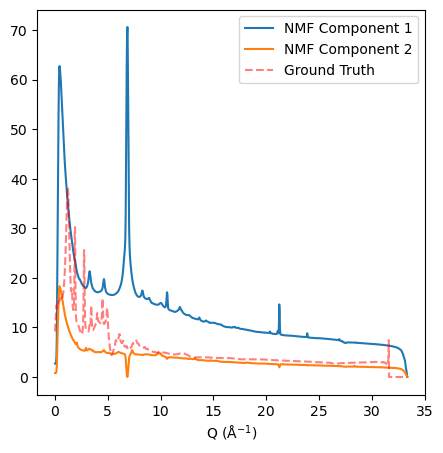

In [13]:
plt.figure(figsize=(5, 5))

plt.plot(q, w[:,0], label='NMF Component 1')
plt.plot(q, w[:,1], label='NMF Component 2')
plt.plot(q, my_ground_truth[:,1]*.1, label='Ground Truth', linestyle='--', c= 'red', alpha = .5)
plt.xlabel(r'Q ($\mathrm{\AA}^{-1}$)')
plt.legend()

plt.show()

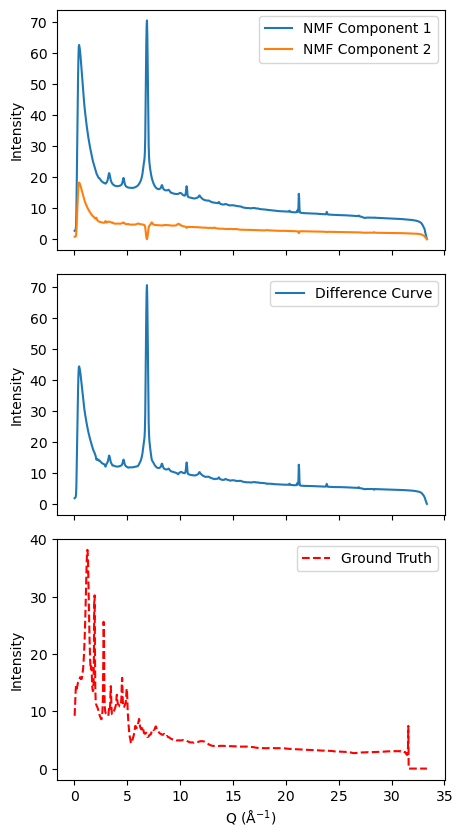

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(5, 10), sharex=True, gridspec_kw={'hspace': 0.1})

# Top plot - NMF Components
ax[0].plot(q, w[:, 0], label='NMF Component 1')
ax[0].plot(q, w[:, 1], label='NMF Component 2')
ax[0].set_ylabel('Intensity')
ax[0].legend()

# Middle plot - Difference Curve

ax[1].plot(q, w[:, 0] - w[:, 1], label='Difference Curve')
ax[1].set_ylabel('Intensity')
ax[1].legend()

# Bottom plot - Ground Truth
ax[2].plot(q, my_ground_truth[:,1]*.1, label='Ground Truth', linestyle='--', c='red')
ax[2].set_xlabel(r'Q ($\mathrm{\AA}^{-1}$)')
ax[2].set_ylabel('Intensity')
ax[2].legend()

plt.show()


In [ ]:
difference_curve = w[:,1] - w[:,0]

In [7]:
import numpy as np
from scipy.optimize import least_squares


def run_least_squares(ground_truth, component, number, q ):
    # Calculate residuals (observed - predicted)
    residuals = ground_truth - component
    # Define the model function for least squares
    def model(x, a, b):
        return a * x + b

    # Define the residual function for least squares
    def residual_func(params, x, y):
        return y - model(x, *params)

    # Initial guess for the parameters (a, b)
    initial_guess = [1, 0]

    # Perform least squares regression
    result = least_squares(residual_func, initial_guess, args=(ground_truth, residuals))

    # Extract the optimized parameters
    a_opt, b_opt = result.x

    # Calculate fitted values
    fitted_values = model(ground_truth, a_opt, b_opt)

    # Quantify the fit using R-squared
    ss_res = np.sum((residuals - fitted_values) ** 2)
    ss_tot = np.sum((residuals - np.mean(residuals)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    print(f"Optimized parameters: a = {a_opt}, b = {b_opt}")
    print(f"R-squared: {r_squared}")

    # # Plot the residuals and the fitted line
    # plt.figure(figsize=(10, 6))
    # plt.scatter(ground_truth, residuals, color='blue', label='Residuals')
    # plt.plot(ground_truth, fitted_values, color='red', label='Fitted Line')
    # plt.axhline(y=0, color='gray', linestyle='--')
    # plt.xlabel('Ground Truth')
    # plt.ylabel('Residuals')
    # plt.title('Least Squares Regression on Residuals on Component {}'.format(number))
    # plt.legend()
    # plt.show()
    
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # Create main figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the residuals and the fitted line
    ax.scatter(ground_truth, residuals, color='blue', label='Residuals\n R-squared: {:.2f}'.format(r_squared))
    ax.plot(ground_truth, fitted_values, color='red', label='Fitted Line')
    ax.axhline(y=0, color='gray', linestyle='--')
    ax.set_xlabel('Ground Truth')
    ax.set_ylabel('Residuals')
    ax.set_title('Least Squares Regression on Residuals on Component {}'.format(number))
    ax.legend()

    # Create inset axes
    ax_inset = inset_axes(ax, width="30%", height="30%", loc="center right")  # Adjust size and location

    # Plot the component vs. ground truth in the inset
    #ax_inset.plot(q, ground_truth, color='blue', alpha=0.6)
    ax_inset.plot(q, component, color='green', alpha=0.8)
    ax_inset.set_xlabel(r'$q\ (\mathrm{\AA}^{-1})$', fontsize=8)
    ax_inset.set_ylabel('Instensity', fontsize=8)
    ax_inset.set_title('Component {}'.format(number), fontsize=10)
    ax_inset.tick_params(axis='both', which='both', labelsize=8)

    plt.show()
    return a_opt, b_opt, r_squared

Optimized parameters: a = 0.7199078255517516, b = -1.2452070820817194
R-squared: 0.9063685021200438


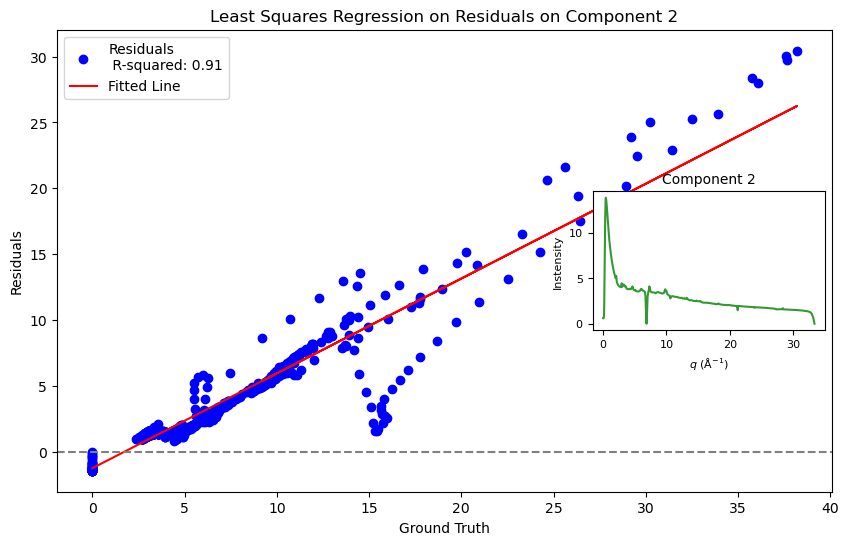

Optimized parameters: a = 0.3583152169447376, b = -3.048339333796124
R-squared: 0.16767593962926108


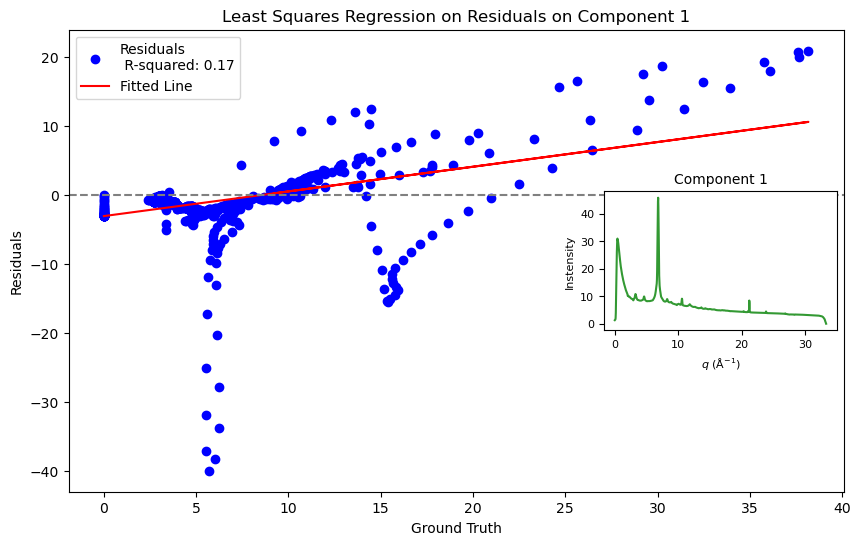

In [49]:
a, b, r = run_least_squares(my_ground_truth[:,1]*.1, w[:,1], number = 2, q=q)
a, b, r = run_least_squares(my_ground_truth[:,1]*.1, w[:,0], number= 1, q=q)

[masked_array(
  data=[[-135.00017100451313, -134.97216689027152, -134.94413749056966,
         ..., -45.05619265132289, -45.02816084175853, -45.00015640746067],
        [-135.02817528583523, -135.0001711717571, -134.97214174542282,
         ..., -45.02818839694317, -45.00015656042945, -44.97215212598207],
        [-135.05620485260465, -135.02820076548636, -135.000171339316,
         ..., -45.00015880320792, -44.972126966543236,
         -44.94412255874272],
        ...,
        [135.0561923155709, 135.02818822843457, 135.00015880225814, ...,
         45.00017134026579, 44.97213950359518, 44.94413509577675],
        [135.0281606735792, 135.000156559494, 134.9721271331666, ...,
         45.028203009199196, 45.00017117269255, 44.972166738238265],
        [135.00015640652705, 134.97215229229232, 134.94412289261135, ...,
         45.05620724928089, 45.028175439737566, 45.00017100544677]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

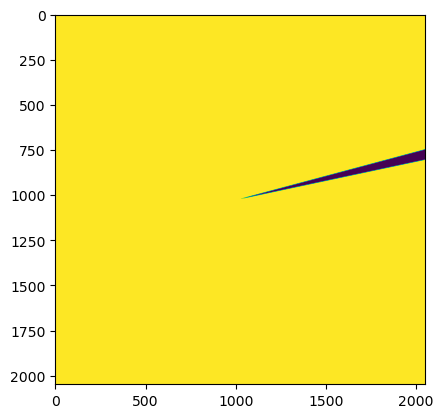

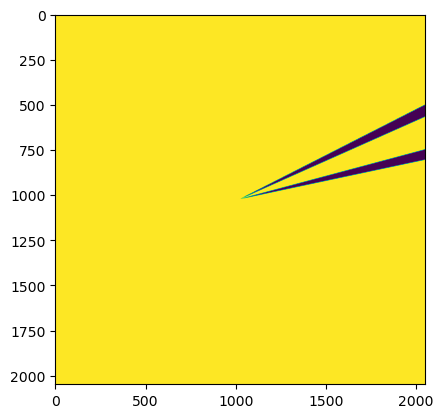

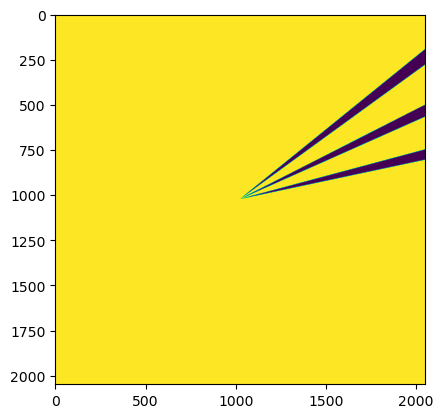

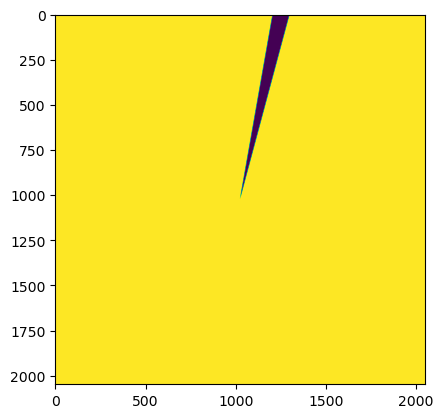

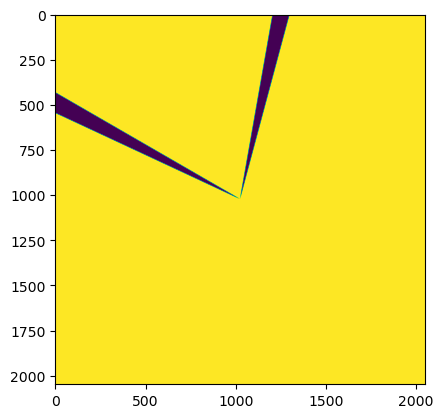

In [8]:
array, ai_pe = masking.make_chi_array(thin_film , .4, .4e-10)
masks = make_masks(array, [1,2,3], offset = 9, width = 3, gits = True)
masks_v2 = make_masks(array, [1,2], offset = 70, width = 5, gits = True)
mask_one = masks[0] 
mask_two = masks[1] 
mask_three = masks[2] 
mask_four = masks_v2[0] 
mask_five = masks_v2[1]

/home/dalverson/miniconda3/envs/venv/lib/python3.11/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


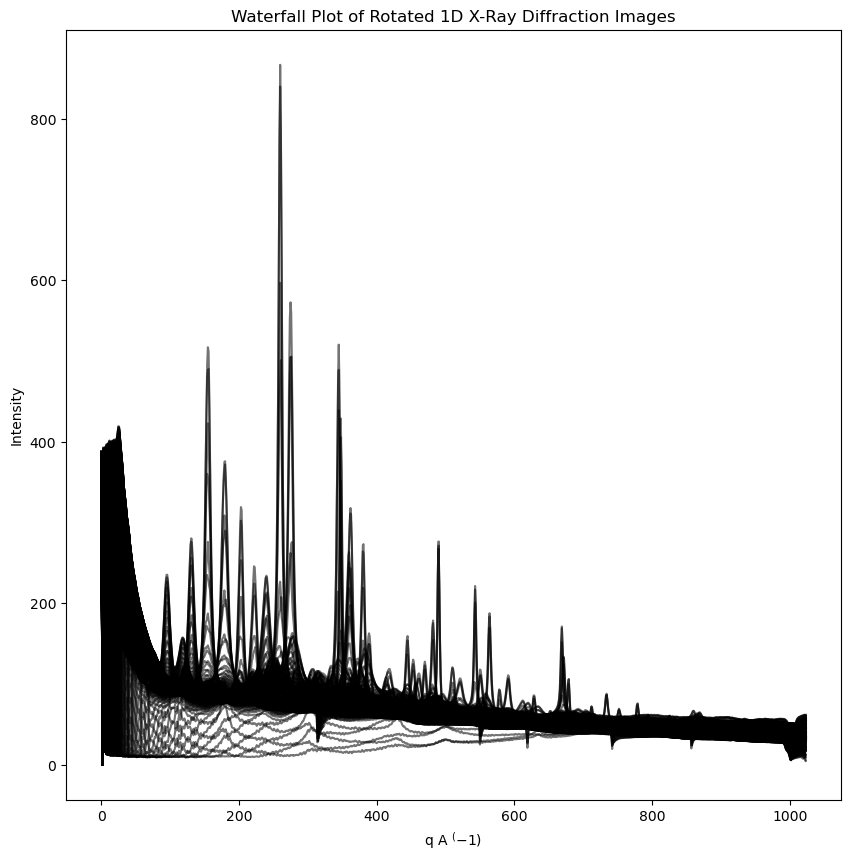

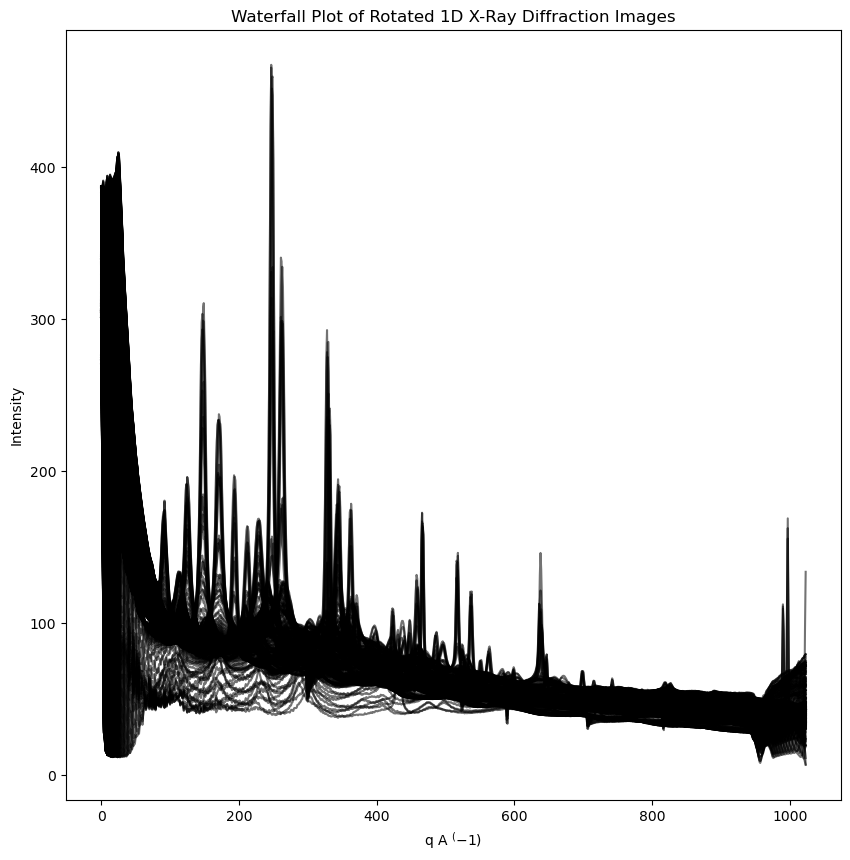

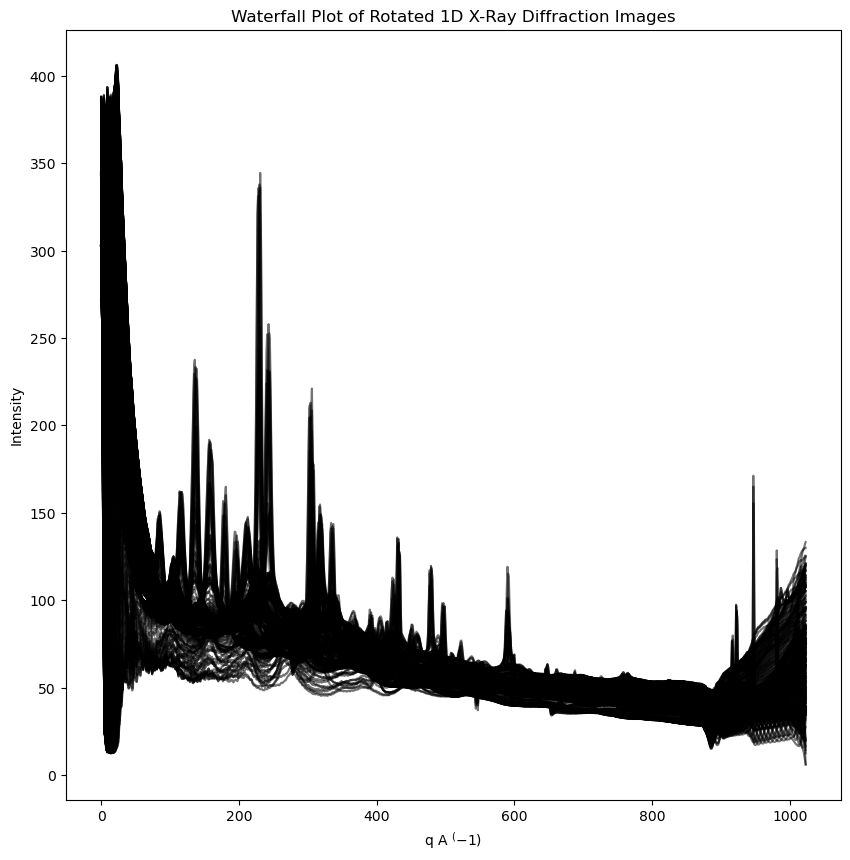

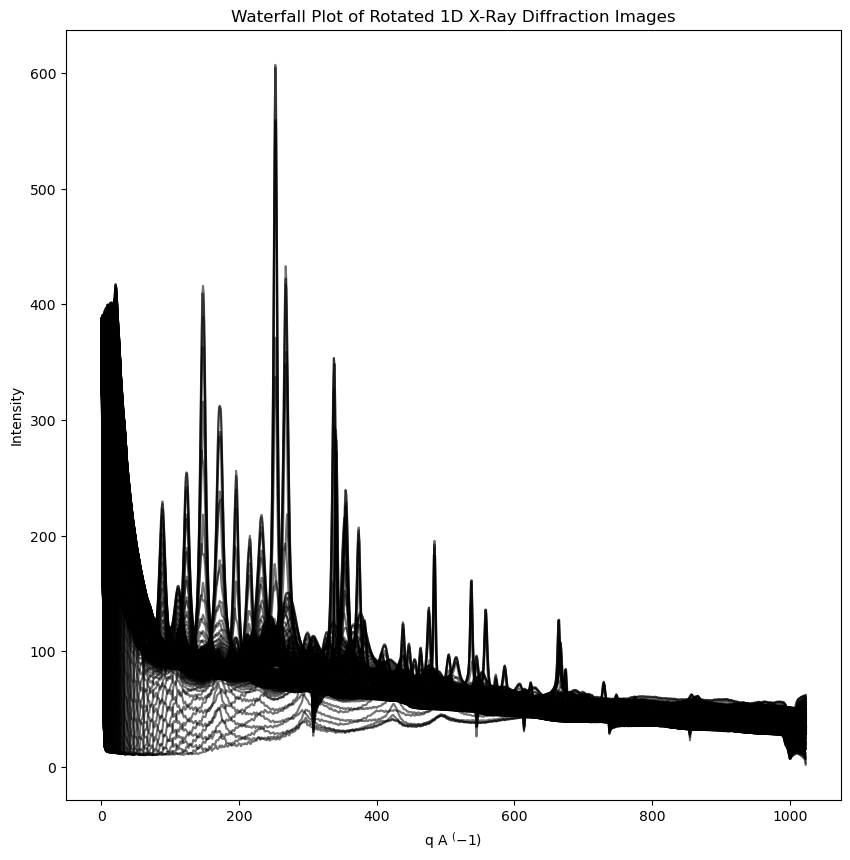

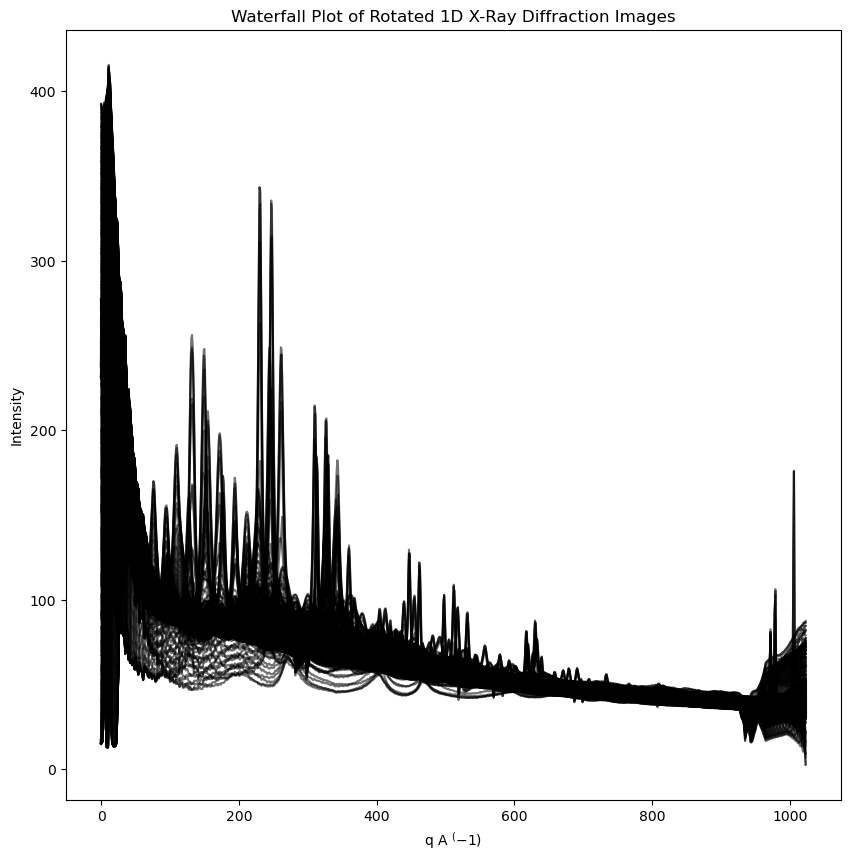

In [9]:
rotated_data = iso.rotate_integrate_image_gpu(image, 1, .4, .4e-10, resolution = 1024, mask = mask_one, poni=my_poni)
rotated_data_v2 = iso.rotate_integrate_image_gpu(image , 1, .4, .4e-10, resolution = 1024, mask = mask_two, poni=my_poni)
rotated_data_v3 = iso.rotate_integrate_image_gpu(image , 1, .4, .4e-10, resolution = 1024, mask = mask_three, poni=my_poni)
rotated_data_v4 = iso.rotate_integrate_image_gpu(image , 1, .4, .4e-10, resolution = 1024, mask = mask_four, poni=my_poni)
rotated_data_v5 = iso.rotate_integrate_image_gpu(image, 1, .4, .4e-10, resolution = 1024, mask = mask_five, poni=my_poni)

In [10]:
column_mapping = {}
for i in range(361, 721):
    column_mapping[(i - 361)] = (i)
rotated_data_v2.rename(columns=column_mapping, inplace=True) 
   
column_mapping = {}
for i in range(722, 1082):
    column_mapping[(i - 722)] = (i)
print(column_mapping)
rotated_data_v3.rename(columns=column_mapping, inplace=True) 

column_mapping = {}
for i in range(1083, 1443):
    column_mapping[(i - 1083)] = (i)
print(column_mapping)
rotated_data_v4.rename(columns=column_mapping, inplace=True)  
  
column_mapping = {}
for i in range(1444, 1804):
    column_mapping[(i - 1444)] = (i)
rotated_data_v5.rename(columns=column_mapping, inplace=True)

combining = pd.concat([rotated_data, rotated_data_v2, rotated_data_v3, rotated_data_v4, rotated_data_v5], axis = 1)
combined_rot_data = combining.clip(lower=0)
combined_rot_data = np.array(combined_rot_data) 

{0: 722, 1: 723, 2: 724, 3: 725, 4: 726, 5: 727, 6: 728, 7: 729, 8: 730, 9: 731, 10: 732, 11: 733, 12: 734, 13: 735, 14: 736, 15: 737, 16: 738, 17: 739, 18: 740, 19: 741, 20: 742, 21: 743, 22: 744, 23: 745, 24: 746, 25: 747, 26: 748, 27: 749, 28: 750, 29: 751, 30: 752, 31: 753, 32: 754, 33: 755, 34: 756, 35: 757, 36: 758, 37: 759, 38: 760, 39: 761, 40: 762, 41: 763, 42: 764, 43: 765, 44: 766, 45: 767, 46: 768, 47: 769, 48: 770, 49: 771, 50: 772, 51: 773, 52: 774, 53: 775, 54: 776, 55: 777, 56: 778, 57: 779, 58: 780, 59: 781, 60: 782, 61: 783, 62: 784, 63: 785, 64: 786, 65: 787, 66: 788, 67: 789, 68: 790, 69: 791, 70: 792, 71: 793, 72: 794, 73: 795, 74: 796, 75: 797, 76: 798, 77: 799, 78: 800, 79: 801, 80: 802, 81: 803, 82: 804, 83: 805, 84: 806, 85: 807, 86: 808, 87: 809, 88: 810, 89: 811, 90: 812, 91: 813, 92: 814, 93: 815, 94: 816, 95: 817, 96: 818, 97: 819, 98: 820, 99: 821, 100: 822, 101: 823, 102: 824, 103: 825, 104: 826, 105: 827, 106: 828, 107: 829, 108: 830, 109: 831, 110: 832,

Starting NMF algorithm with the following parameters:

Max components: 200
Max iterations: 100
Init: random
Solver: cd
Tolerance: 0.0001
Patience: 5
Random
Random initializers completed
Continuing with best run parameters that are init: nndsvd, solver: cd, tol: 1e-05
Run with 1 components has been completed
Run with 2 components has been completed
Run with 3 components has been completed
Run with 4 components has been completed
Run with 5 components has been completed
Run with 6 components has been completed
Run with 7 components has been completed
Run with 8 components has been completed
Run with 9 components has been completed
Run with 10 components has been completed
Run with 11 components has been completed
Run with 12 components has been completed
Run with 13 components has been completed
Run with 14 components has been completed
Run with 15 components has been completed
Run with 16 components has been completed
Run with 17 components has been completed
Run with 18 components has 

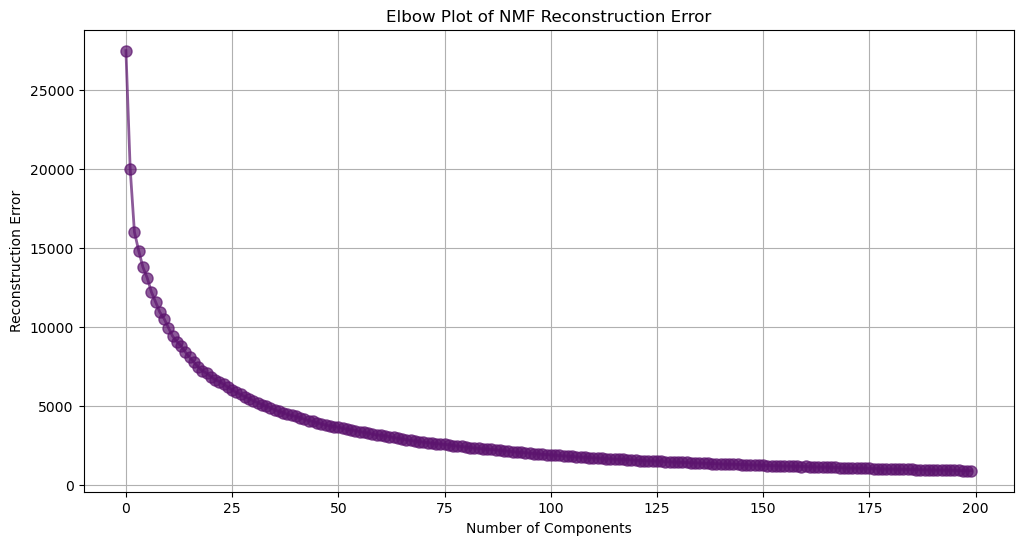

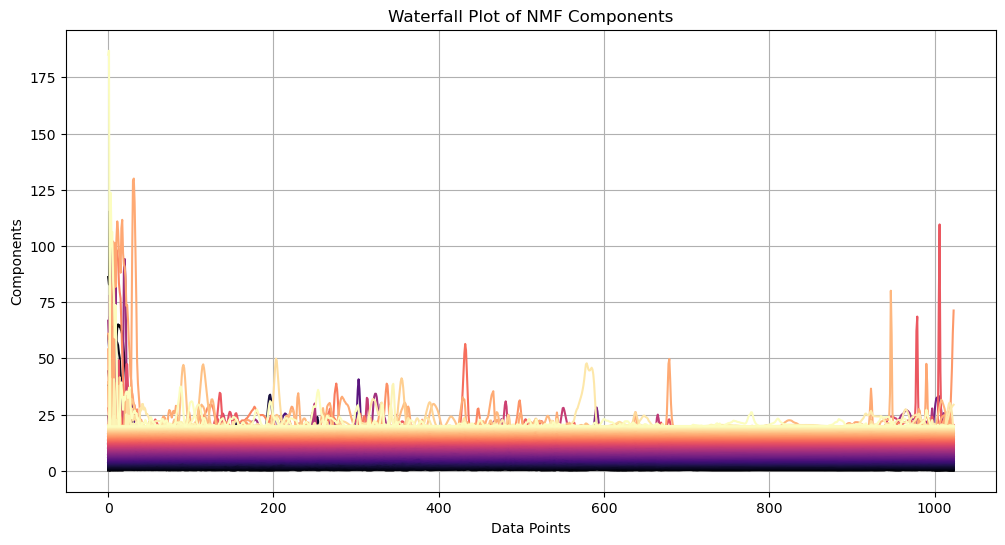

The best number of components is 200


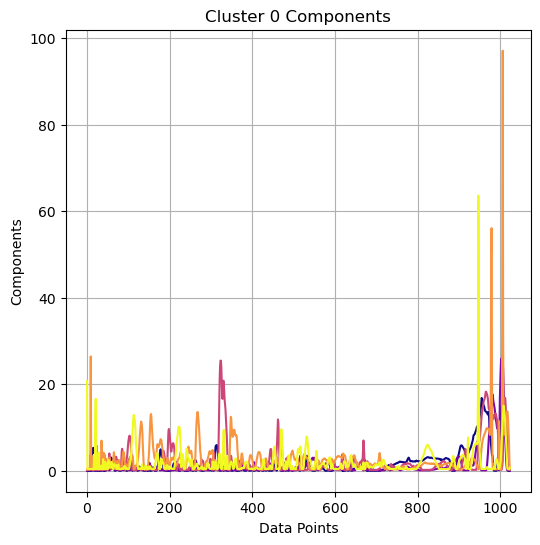

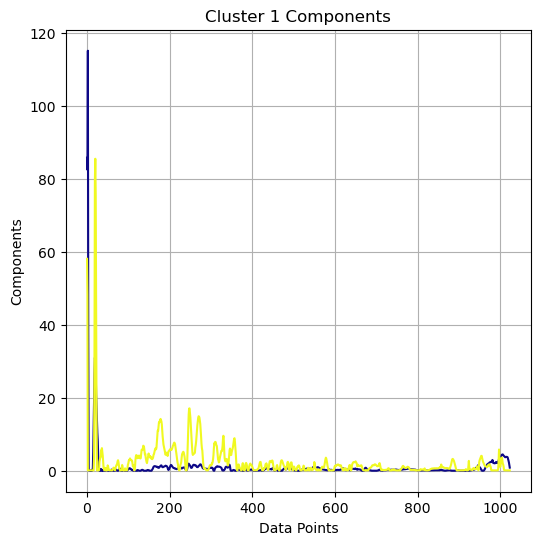

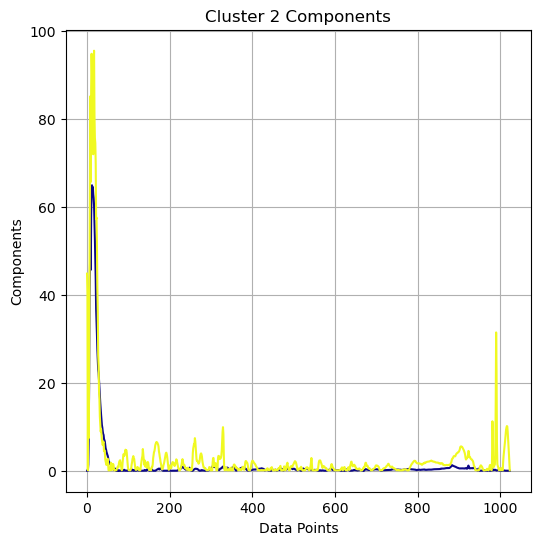

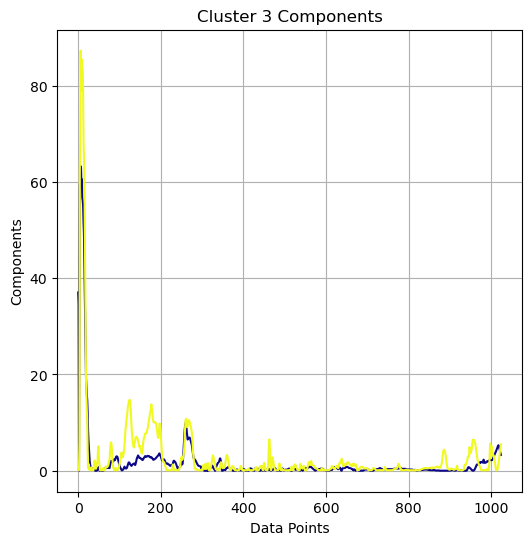

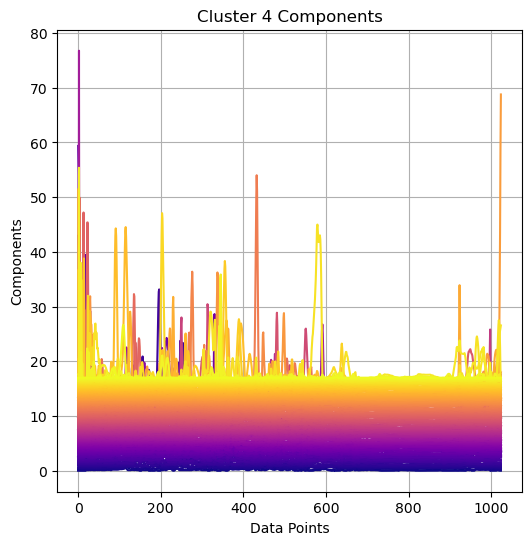

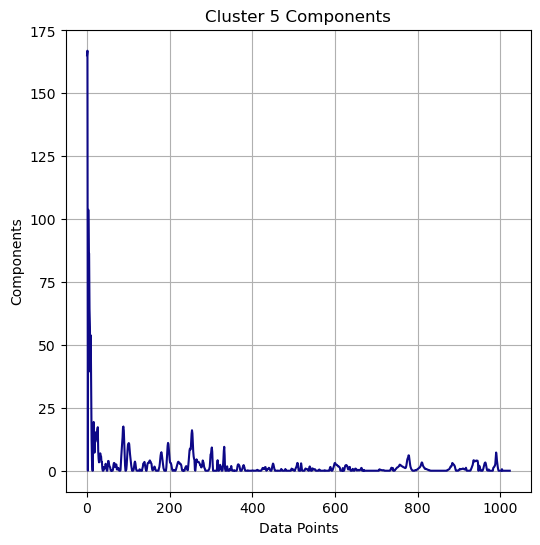

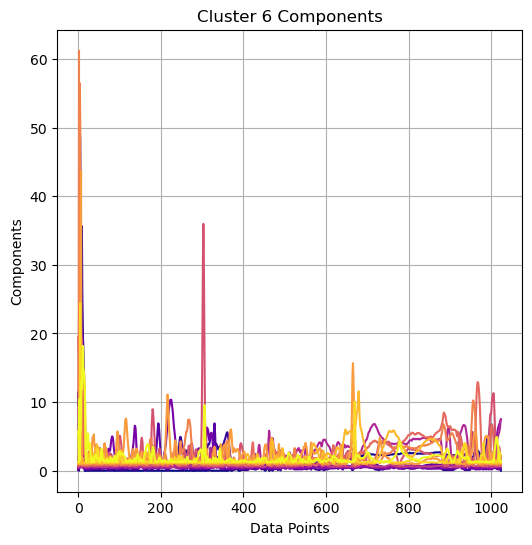

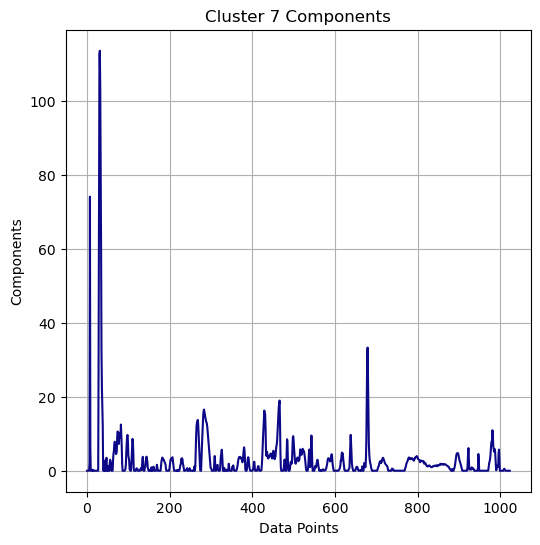

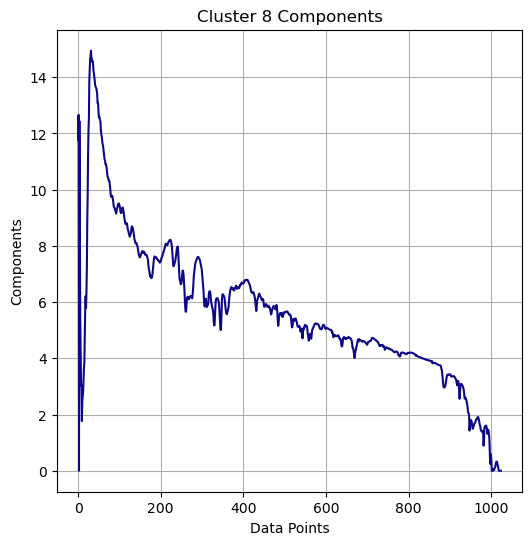

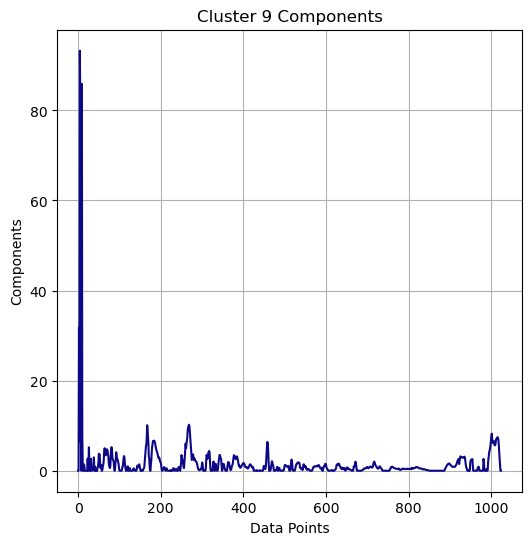

In [32]:
best_W, best_H, best_reconstruction_err, data_dict =  iso.run_sklearn_nmf_and_agg_cluster(combined_rot_data, max_components = 200, max_iter = 100, n_clusters = 10, cluster_matrix = 'W')

In [33]:
from scipy.signal import savgol_filter

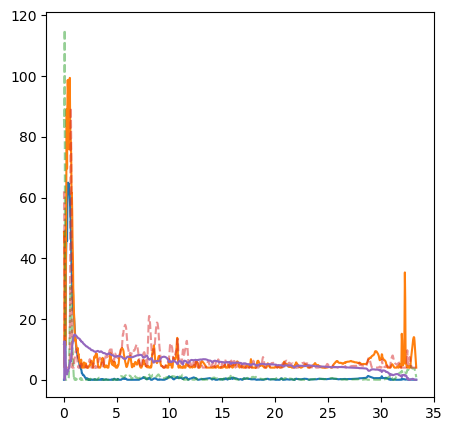

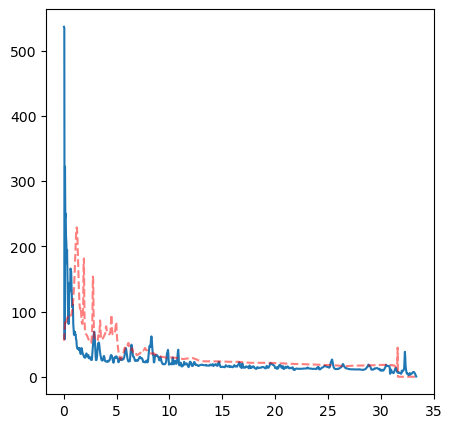

In [106]:
plt.figure(figsize=(5,5))

for i in range(len(data_dict[2])):
    plt.plot(q, data_dict[2][i]+4*i, label='Component {}'.format(i))
for i in range(len(data_dict[2])):
    plt.plot(q, data_dict[1][i]+4*i, label='NMF Component {}'.format(i), linestyle='--', alpha=.5)
plt.plot(q, data_dict[8][0])


plt.figure(figsize=(5,5))

my_comp = (data_dict[2][0] + data_dict[2][1]+ data_dict[1][0] + data_dict[1][1] + (data_dict[8][0]*5) + data_dict[5][0]*5)/2
plt.plot(q, my_comp, label='Combined Component')
plt.plot(q, my_ground_truth[:,1]*.6, label='Ground Truth', linestyle='--', c= 'red', alpha = .5)

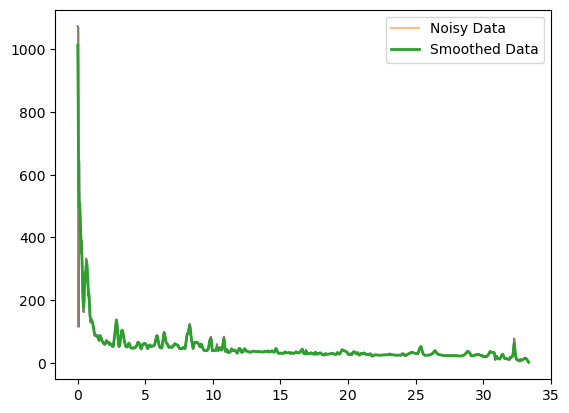

In [101]:
plt.plot(q, my_comp)

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Apply Gaussian smoothing
sigma = 1 # Standard deviation of the Gaussian kernel
y_smooth = gaussian_filter1d(my_comp, sigma)

# Plot results
plt.plot(q, my_comp, label="Noisy Data", alpha=0.5)
plt.plot(q, y_smooth, label="Smoothed Data", linewidth=2)
plt.legend()
plt.show()

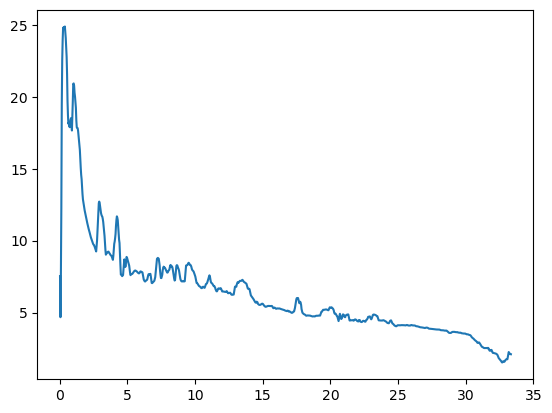

In [72]:
#plt.plot(data_dict[4][0])
#plt.plot(data_dict[0][16])

from scipy.signal import savgol_filter

nmf_comp = savgol_filter((data_dict[4][0] + data_dict[0][16]*.5), 3, 1)

plt.plot(q, nmf_comp)

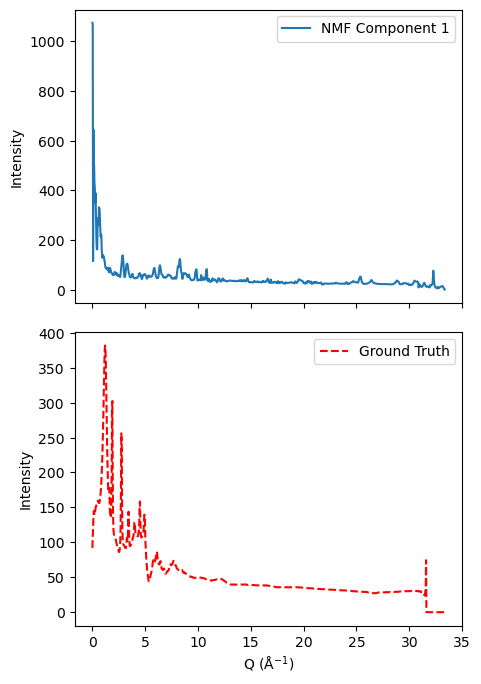

In [103]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(5, 8), sharex=True, gridspec_kw={'hspace': 0.1})

# Top plot - NMF Components
ax[0].plot(q, my_comp, label='NMF Component 1')
#ax[0].plot(q, w[:, 1], label='NMF Component 2')
ax[0].set_ylabel('Intensity')
ax[0].legend()

# Bottom plot - Ground Truth
ax[1].plot(q, my_ground_truth[:,1], label='Ground Truth', linestyle='--', c='red')
ax[1].set_xlabel(r'Q ($\mathrm{\AA}^{-1}$)')
ax[1].set_ylabel('Intensity')
ax[1].legend()

plt.show()

Optimized parameters: a = 0.6978682756801994, b = -7.590243627762093
R-squared: 0.5637607938633701


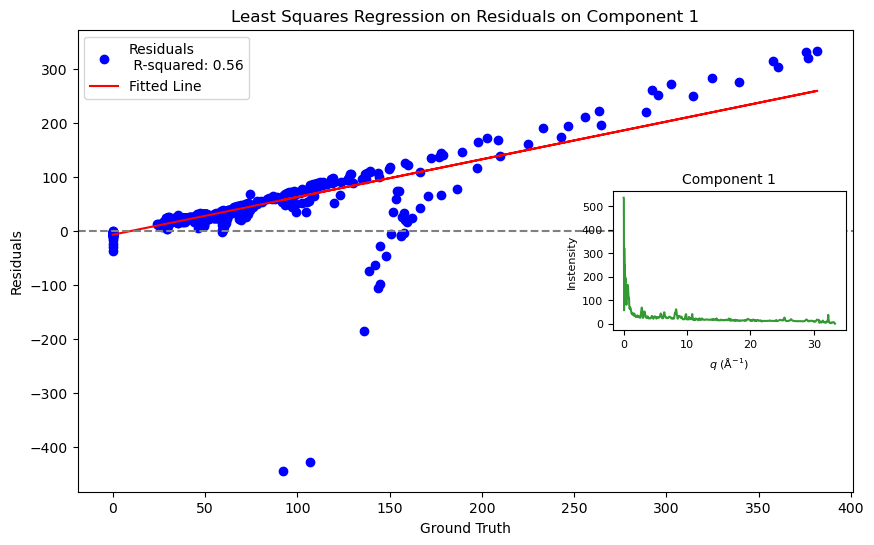

In [107]:
a, b, r = run_least_squares(my_ground_truth[:,1], my_comp, number = 1, q=q)